# Применение Pytorch для классификации MNIST/EMNIST

In [1]:
import torch
import numpy as np
from numpy import  vstack, argmax
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from torch import Tensor, flatten
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split

from torch.nn import Linear,ReLU, Sigmoid, Module, BCELoss, CrossEntropyLoss, Flatten, Softmax, Conv2d, MaxPool2d, MultiLabelMarginLoss
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.optim import SGD
from torch.nn.functional import one_hot

from torchvision.datasets import MNIST, EMNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda

from mlxtend.data import loadlocal_mnist

In [2]:
class CSVLoader(Dataset):

  def __init__(self,path):
    super(CSVLoader,self).__init__()
    df = pd.read_csv(path, header=None)
    self.X = df.values[:,:-1].astype('float32')
    self.Y = LabelEncoder().fit_transform(df.values[:,-1]).astype('float32')
    self.Y = self.Y.reshape(len(self.Y),1)
    self.shape=df.shape

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    return [self.X[idx],self.Y[idx]]

  def get_splits(self,n_test=0.33):
    test_size = round(n_test * len(self.X))
    train_size = len(self.X) - test_size
    return random_split(self,[train_size,test_size])

class DtLoader(Dataset):

  def __init__(self,X,y):
    super(DtLoader,self).__init__()
    self.data = X
    self.targets = y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    return [self.data[idx],self.targets[idx]]

class NN(Module):

  def __init__(self,n_inputs,n_outputs,hidden_sizes):
    super(NN,self).__init__()
    self.layer = Linear(n_inputs,hidden_sizes[0])
    kaiming_uniform_(self.layer.weight, nonlinearity='relu')
    self.activation = ReLU()

    # 2 -layer
    self.layer2 = Linear(hidden_sizes[0],hidden_sizes[1])
    kaiming_uniform_(self.layer2.weight, nonlinearity='relu')
    self.activation2 = ReLU()

    # 3 output layer
    self.output = Linear(hidden_sizes[1],n_outputs)
    xavier_uniform_(self.output.weight)
    self.activation3 = Sigmoid()

  def forward(self,X):
    X = self.layer(X)
    X = self.activation(X)
    X = self.layer2(X)
    X = self.activation2(X)
    X = self.output(X)
    X = self.activation3(X)
    return X

In [3]:
#общие функции
def prepare_dataset(path):
  dataset = CSVLoader(path)
  train,test = dataset.get_splits()
  train_dl = DataLoader(train,batch_size=32,shuffle=True)
  test_dl =  DataLoader(test,batch_size=32,shuffle=False)
  return train_dl,test_dl

def train_model(train_dl, model,loss,epoches,flatten):
    # define the optimization
    cost = loss() #MSELoss , CrossEntropyLoss -multiclass , BCELoss - binary classification
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epoches):
        for i, (x_train,y_train) in enumerate(train_dl):
            if flatten:
              x_train = x_train.view(x_train.shape[0], -1)
            optimizer.zero_grad()
            yhat = model(x_train)
            loss = cost(yhat, y_train)
            loss.backward()
            optimizer.step()


def evaluate(test_dl,model):
  predictions, actuals = list(), list()
  for i, (x_test,y_test) in enumerate(test_dl):
    yhat = model(x_test)
    yhat = yhat.detach().numpy().round()
    actual = y_test.numpy()
    actual = actual.reshape(len(actual),1)
    predictions.append(yhat)
    actuals.append(actual)
  
  predictions, actuals = vstack(predictions), vstack(actuals)
  acc = accuracy_score(actuals,  predictions)
  return acc


def evaluate_model(test_dl, model,flatten):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        if flatten:
          inputs=inputs.view(inputs.shape[0],-1)
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        yhat = argmax(yhat, axis=1)
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc


def predict(row,model):
  row = Tensor([row]).float()
  yhat = model(row)
  yhat = yhat.detach().numpy()
  return yhat


def prepare_data(path,dsname,split,n_outputs):
    if split!=None:
      train = dsname(path, train=True, download=True, split=split,transform=ToTensor())
      test = dsname(path, train=False, download=True, split=split,transform=ToTensor())     
    else:
      #преобразование для данных mnist
      trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
      train = dsname(path, train=True, download=True, transform=trans)
      test = dsname(path, train=False, download=True, transform=trans)
    
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=64, shuffle=False)
    LE = LabelEncoder()
    train_dl.dataset.targets=Tensor(LE.fit_transform(train_dl.dataset.targets))
    test_dl.dataset.targets=Tensor(LE.transform(test_dl.dataset.targets))

    return train_dl, test_dl


def prepare_data_one_hot(path,dsname,split,n_outputs):
    if split!=None:
      train = dsname(path, train=True, download=True, split=split,transform=ToTensor())
      test = dsname(path, train=False, download=True, split=split,transform=ToTensor())     
    else:
      #преобразование для данных mnist
      trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
      train = dsname(path, train=True, download=True, transform=trans)
      test = dsname(path, train=False, download=True, transform=trans)
    
    train_dl = DataLoader(train, batch_size=64, shuffle=True)
    test_dl = DataLoader(test, batch_size=64, shuffle=False)
    LE = LabelEncoder()
    #train_dl.dataset.targets=Tensor(LE.fit_transform(train_dl.dataset.targets))
    #test_dl.dataset.targets=Tensor(LE.transform(test_dl.dataset.targets))

    train_data=train_dl.dataset.data.detach().clone() 
    test_data=test_dl.dataset.data.detach().clone()

    train_targets = train_dl.dataset.targets.detach().clone()
    test_targets = test_dl.dataset.targets.detach().clone()

    train_indices = Tensor(LE.fit_transform(train_targets)).long()
    train_one_hot = torch.nn.functional.one_hot(train_indices, n_outputs)
    #train_dl.dataset.targets=train_one_hot

    test_indices = Tensor(LE.transform(test_targets)).long()
    test_one_hot = torch.nn.functional.one_hot(test_indices, n_outputs)
    #test_dl.dataset.targets=test_one_hot

    train_dataset=DtLoader(train_data.detach().clone(),torch.tensor(train_one_hot,dtype=torch.long))
    test_dataset=DtLoader(test_data.detach().clone(),torch.tensor(test_one_hot,dtype=torch.long))

    train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
    test_dl =  DataLoader(test_dataset,batch_size=32,shuffle=False)

    return train_dl, test_dl


def show_batch(batch,trans):
  im = make_grid(batch)
  plt.figure(figsize = (10,10))
  if trans:
    plt.imshow(np.transpose(im.numpy()))
  else:
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


def pca_transform(train,test,n_components_pca):

  scaler_emnist = StandardScaler()
  pca_emnist=PCA(n_components=n_components_pca)
  LE = LabelEncoder()
  size=train.dataset.data.shape[1]

  train_data=train.dataset.data.clone().detach()
  test_data=test.dataset.data.clone().detach()

  train_trans=pca_emnist.fit_transform(scaler_emnist.fit_transform(train_data.reshape(-1,size**2)))
  test_trans= pca_emnist.transform(scaler_emnist.transform(test_data.reshape(-1,size**2)))

  #train_targets = LE.fit_transform(train.dataset.targets)
  #test_targets = LE.transform(test.dataset.targets)
  train_targets = train.dataset.targets.clone().detach().long()
  test_targets = test.dataset.targets.clone().detach().long()

  train_dataset=DtLoader(Tensor(train_trans),train_targets.clone().detach())
  test_dataset=DtLoader(Tensor(test_trans),test_targets.clone().detach())

  train = DataLoader(train_dataset,batch_size=32,shuffle=True)
  test =  DataLoader(test_dataset,batch_size=32,shuffle=False)

  return train, test

# Загрузка данных

In [4]:
#emnist
n_outputs=26
train_emnist, test_emnist = prepare_data('~/.torch/datasets/emnist',EMNIST,'letters',n_outputs)

#mnist
n_outputs=10
train_mnist, test_mnist = prepare_data('~/.torch/datasets/mnist',MNIST,None,n_outputs)

#emnist pca
pca_components=0.9
train_emnist_pca, test_emnist_pca = pca_transform(train_emnist, test_emnist,pca_components)

#mnist pca
train_mnist_pca, test_mnist_pca = pca_transform(train_mnist, test_mnist,pca_components)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
'''one-hot encoding
#emnist
n_outputs=26
train_emnist, test_emnist = prepare_data_one_hot('~/.torch/datasets/emnist',EMNIST,'letters',n_outputs)

#mnist
n_outputs=10
train_mnist, test_mnist = prepare_data_one_hot('~/.torch/datasets/mnist',MNIST,None,n_outputs)

#emnist pca
pca_components=0.9
train_emnist_pca, test_emnist_pca = pca_transform(train_emnist, test_emnist,pca_components)

#mnist pca
train_mnist_pca, test_mnist_pca = pca_transform(train_mnist, test_mnist,pca_components)'''

"one-hot encoding\n#emnist\nn_outputs=26\ntrain_emnist, test_emnist = prepare_data_one_hot('~/.torch/datasets/emnist',EMNIST,'letters',n_outputs)\n\n#mnist\nn_outputs=10\ntrain_mnist, test_mnist = prepare_data_one_hot('~/.torch/datasets/mnist',MNIST,None,n_outputs)\n\n#emnist pca\npca_components=0.9\ntrain_emnist_pca, test_emnist_pca = pca_transform(train_emnist, test_emnist,pca_components)\n\n#mnist pca\ntrain_mnist_pca, test_mnist_pca = pca_transform(train_mnist, test_mnist,pca_components)"

# Простая полносвязная нейронная сеть

In [6]:
#пример из практики для быстрой проверки
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'
train_dl, test_dl = prepare_dataset(path)

print(len(train_dl.dataset),len(test_dl.dataset))

input_size = train_dl.dataset.dataset.shape[1]-1
hidden_sizes = [10, 8]
output_size = 1

model = NN(input_size,output_size,hidden_sizes)
time1=time.time()
train_model(train_dl,model,BCELoss,100,False)
time2=time.time()
acc = evaluate(test_dl,model)

print('Accuracy: {}, training time: {} sec, evaluating time: {} sec'.format(acc,time2-time1,time.time()-time2))
row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
yhat = predict(row,model)

print(yhat)


235 116
Accuracy: 0.9310344827586207, training time: 1.0004725456237793 sec, evaluating time: 0.0031795501708984375 sec
[[0.99968314]]


Обучение простой полносвязной нейронной сети на данных EMNIST из соревнования kaggle


Добавить в класс Dataset преобразование PCA

In [7]:
#MNIST/EMNIST полносвязные сети
input_size = 28*28
hidden_sizes = [128, 64]
output_size_emnist = 26
emnist_model = NN(input_size,output_size_emnist,hidden_sizes)

output_size_mnist = 10
mnist_model = NN(input_size,output_size_mnist,hidden_sizes)



In [8]:
#emnist pca
input_size = train_emnist_pca.dataset.data.shape[1]
hidden_sizes = [128, 64] 
output_size_emnist = 26
emnist_model_pca = NN(input_size,output_size_emnist,hidden_sizes)


#mnist pca
input_size = train_mnist_pca.dataset.data.shape[1]
hidden_sizes = [128, 64]
output_size_mnist = 10
mnist_model_pca = NN(input_size,output_size_mnist,hidden_sizes)

In [9]:
n_epoches=3
for model,train,test,name,flat in zip([mnist_model_pca, emnist_model, mnist_model, emnist_model_pca],
                            [train_mnist_pca,train_emnist,train_mnist,train_emnist_pca],
                            [test_mnist_pca, test_emnist,test_mnist,test_emnist_pca],
                            ['mnist_model_pca', 'emnist_model', 'mnist_model', 'emnist_model_pca' ],
                            [False, True,True,False]):
  time1=time.time()
  train_model(train, model, CrossEntropyLoss,n_epoches,flat)
  time2=time.time()
  print('for {} accuracy: {}, training time: {} sec, evaluating time: {} sec'.format(name, evaluate_model(test,model,flat),time2-time1,time.time()-time2))


for mnist_model_pca accuracy: 0.9507, training time: 8.946056604385376 sec, evaluating time: 0.15942692756652832 sec
for emnist_model accuracy: 0.7353365384615385, training time: 66.07285737991333 sec, evaluating time: 3.205580949783325 sec
for mnist_model accuracy: 0.9516, training time: 48.01004123687744 sec, evaluating time: 2.5058958530426025 sec
for emnist_model_pca accuracy: 0.8228846153846154, training time: 15.094227075576782 sec, evaluating time: 0.33666443824768066 sec


PCA преобразование в 3-4 раза снижает время обучения модели. В случае emnist повышает точность, а в случае mnist остается примерно на том же уровне.

# CNN

Дописать код из практического занятия, так , чтобы модель CNN обучилась на MNIST данных

In [10]:
class CNN(Module):
    def __init__(self, n_color_channels, n_inputs, n_outputs):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_color_channels, 32*n_color_channels, (3,3))
        n_inputs-=2
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        n_inputs//=2
        # second hidden layer
        self.hidden2 = Conv2d(32*n_color_channels, 32*n_color_channels, (3,3))
        n_inputs-=2
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        n_inputs//=2
        # fully connected layer
        self.hidden3 = Linear(n_inputs*n_inputs*32*n_color_channels, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, n_outputs)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)


    def forward(self, X):
        #X.permute(0,3,1,2)
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        # flatten
        #X = X.view(-1, 4*4*50)
        X=Flatten()(X)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        X = self.hidden4(X)
        X = self.act4(X)
        return X


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


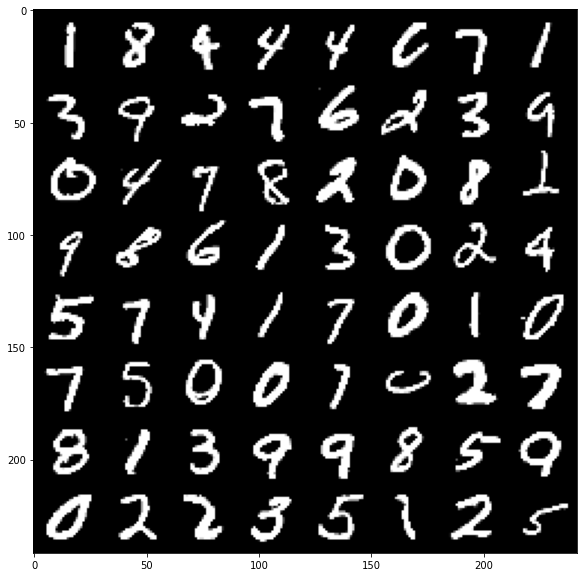

In [11]:
#визуализация
dataiter = iter(train_mnist)
images, labels = dataiter.next()

show_batch(images,False)

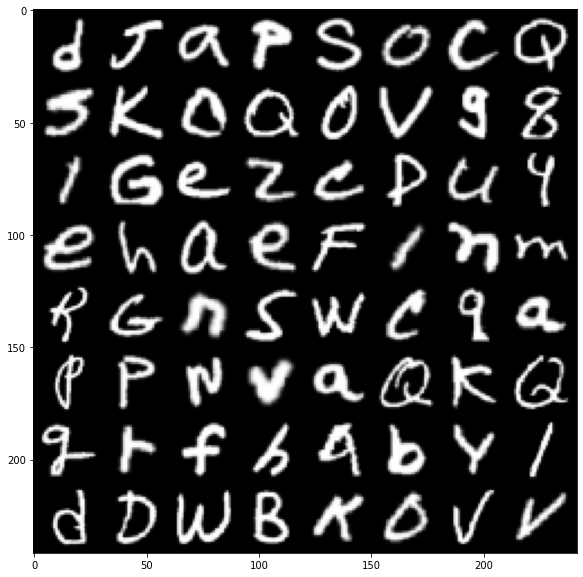

In [12]:
dataiter = iter(train_emnist)
images, labels = dataiter.next()

show_batch(images,True)

In [13]:
#создание и обучение модели mnist
n_color_channels=1
n_inputs=28
n_outputs=10
n_epoches=10
flatten=False
cnn=CNN(n_color_channels,n_inputs,n_outputs)
time1=time.time()
train_model(train_mnist, cnn, CrossEntropyLoss,n_epoches,flatten)
time2=time.time()

#оценка
print('for CNN mnist accuracy: {}, training time: {} sec, evaluating time: {} sec'.format(evaluate_model(test_mnist,cnn,flatten),time2-time1,time.time()-time2))
 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


for CNN mnist accuracy: 0.9871, training time: 471.3407230377197 sec, evaluating time: 4.968408107757568 sec


In [14]:
#создание и обучение модели emnist
n_color_channels=1
n_inputs=28
n_outputs=26
n_epoches=2
flatten=False
cnn_emnist=CNN(n_color_channels,n_inputs,n_outputs)
time1=time.time()
train_model(train_emnist, cnn_emnist, CrossEntropyLoss,n_epoches,flatten)
time2=time.time()
#оценка
print('for CNN mnist accuracy: {}, training time: {} sec, evaluating time: {} sec'.format(evaluate_model(test_emnist,cnn_emnist,flatten),time2-time1,time.time()-time2))

for CNN mnist accuracy: 0.6165384615384616, training time: 865.3969588279724 sec, evaluating time: 8.273527383804321 sec


# CNN CIFAR

In [16]:
#cifar
train_cifar, test_cifar = prepare_data('~/.torch/datasets/cifar',CIFAR10,None,10)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.torch/datasets/cifar/cifar-10-python.tar.gz to /root/.torch/datasets/cifar
Files already downloaded and verified


In [17]:
#train_cifar.dataset.targets=torch.tensor(train_cifar.dataset.targets,dtype=torch.long)
tens=train_cifar.dataset.targets.detach().clone()
train_cifar.dataset.targets=torch.tensor(tens,dtype=torch.long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


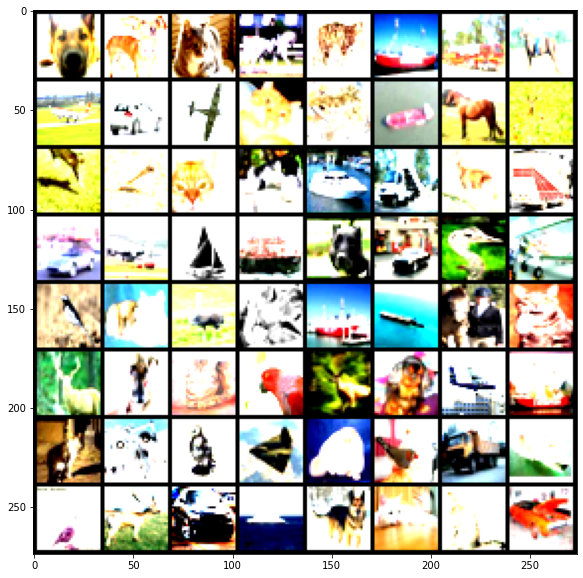

In [18]:
#визуализация
dataiter = iter(train_cifar)
images, labels = dataiter.next()

show_batch(images,False)

In [19]:
#создание и обучение модели
cnn_cifar=CNN(3,32,10)
train_model(train_cifar, cnn_cifar,CrossEntropyLoss,1,False)

In [20]:
evaluate_model(test_cifar,cnn_cifar,False)

0.4124